In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import kerastuner as kt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import backend as K
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import RSquare


Using TensorFlow backend


/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_14226/1610707655.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt
/Users/abdullamashaly/anaconda3/envs/dev/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/abdullamashaly/anaconda3/envs/dev/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (n

## Preprocessing

In [2]:
#  Import and read the charity_data.csv.
book_df = pd.read_csv("../../Resources/panda_df/books_cleaned_sampleFinal1.csv")
book_df.head()

/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_14226/3613846910.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  book_df = pd.read_csv("Resources/panda_df/books_cleaned_sampleFinal1.csv")


,isbn13,average_rating,book_id,format,num_pages,publication_year,ratings_count,text_reviews_count,author_average_rating
0,0000000067317,4.36,2745937,other,298,1994,27,2,4.140
1,0000195118146,3.75,679038,Paperback,448,1997,44,4,3.865
2,0000195397916,3.32,7272274,Hardcover,208,2010,86,15,3.370
3,0000262541785,4.06,593335,Paperback,233,2004,138,11,4.060
4,0000340826681,4.09,332824,Paperback,288,2004,32,2,4.100


In [3]:
# Determine the number of unique values in each column.
book_df.nunique()

isbn13                   838200
average_rating              352
book_id                  838200
format                        4
num_pages                  1445
publication_year            117
ratings_count             15648
text_reviews_count         3853
author_average_rating      5830
dtype: int64

In [4]:
# Drop the non-beneficial book_id and ISBN13 columns.
book_df = book_df.drop(["book_id", "isbn13"],axis=1)
book_df.head()

,average_rating,format,num_pages,publication_year,ratings_count,text_reviews_count,author_average_rating
0,4.36,other,298,1994,27,2,4.140
1,3.75,Paperback,448,1997,44,4,3.865
2,3.32,Hardcover,208,2010,86,15,3.370
3,4.06,Paperback,233,2004,138,11,4.060
4,4.09,Paperback,288,2004,32,2,4.100


In [5]:
# Convert categorical data to numeric with `pd.get_dummies`
book_df = pd.get_dummies(book_df)

In [6]:
book_df.head()

,average_rating,num_pages,publication_year,ratings_count,text_reviews_count,author_average_rating,format_Hardcover,format_Paperback,format_ebook,format_other
0,4.36,298,1994,27,2,4.140,0,0,0,1
1,3.75,448,1997,44,4,3.865,0,1,0,0
2,3.32,208,2010,86,15,3.370,1,0,0,0
3,4.06,233,2004,138,11,4.060,0,1,0,0
4,4.09,288,2004,32,2,4.100,0,1,0,0


In [9]:
# Split our preprocessed data into our features and target arrays
features = book_df.drop(columns=["average_rating"])
target = book_df["average_rating"]
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [10]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Identify the best hyperparameters using keras tuner

In [12]:
# Define keras tuner function
def build_model(hp):
    model = Sequential()

    #Allow Kerastuner to decide which activation function to use in the hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid', 'leaky_relu'])

    # Tune the number of units in the first Dense layer
    model.add(Dense(hp.Int('input_units', min_value=20, max_value=200, step=10), activation=activation, input_dim=9))

    # Tune the number of hidden layers and the number of units in each layer
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=256, step=32), activation='relu'))

    # Output layer for regression
    model.add(Dense(units=1, activation='linear'))  
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                loss='mean_squared_error',
                metrics=[RSquare(), 'mean_squared_error'])
    return model

tuner = kt.Hyperband(build_model,
                    objective=kt.Objective('r_square', direction="max"),
                    max_epochs=50,
                    factor=3,
                    project_name='keras_tuner_1.1')

tuner.search(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 84 Complete [00h 07m 33s]
r_square: 0.5779497027397156

Best r_square So Far: 0.5857383608818054
Total elapsed time: 03h 24m 35s


In [13]:
# View the best hyperparameters
best_hps.values

{'activation': 'tanh',
 'input_units': 180,
 'n_layers': 3,
 'dense_0_units': 192,
 'learning_rate': 0.0006177020005809435,
 'dense_1_units': 224,
 'dense_2_units': 96,
 'dense_3_units': 64,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0069'}

## Compile, Train and Evaluate the Model

In [14]:
# Define the model with the suggested hyperparameters
model = Sequential()

# Add the first Dense layer with the optimal number of units from the hyperparameter tuner
model.add(Dense(units=best_hps.get('input_units'), activation=best_hps.get('activation'), input_dim=9))

# Add the hidden layers, with the number of units being tuned
for i in range(best_hps.get('n_layers')):
    model.add(Dense(units=best_hps.get(f'dense_{i}_units'), activation='relu'))

# Add the output layer
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
            loss='mean_squared_error',
            metrics=['mean_absolute_error', 'mean_squared_error', RSquare()])

In [15]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/100
19646/19646 [==============================] - 19s 963us/step - loss: 0.0668 - mean_absolute_error: 0.1827 - mean_squared_error: 0.0668 - r_square: 0.4883 - val_loss: 0.0586 - val_mean_absolute_error: 0.1791 - val_mean_squared_error: 0.0586 - val_r_square: 0.5511
Epoch 2/100
19646/19646 [==============================] - 19s 960us/step - loss: 0.0567 - mean_absolute_error: 0.1714 - mean_squared_error: 0.0567 - r_square: 0.5655 - val_loss: 0.0566 - val_mean_absolute_error: 0.1752 - val_mean_squared_error: 0.0566 - val_r_square: 0.5667
Epoch 3/100
19646/19646 [==============================] - 19s 981us/step - loss: 0.0556 - mean_absolute_error: 0.1687 - mean_squared_error: 0.0556 - r_square: 0.5742 - val_loss: 0.0547 - val_mean_absolute_error: 0.1654 - val_mean_squared_error: 0.0547 - val_r_square: 0.5812
Epoch 4/100
19646/19646 [==============================] - 20s 997us/step - loss: 0.0552 - mean_absolute_error: 0.1678 - mean_squared_error: 0.0552 - r_square: 0.5771 - val

In [16]:
# Predicted values
predicted_ratings = model.predict(X_test_scaled)
actual_ratings = y_test

# Create a DataFrame with the actual and predicted values
ratings = pd.DataFrame({"Actual": actual_ratings, "Predicted": predicted_ratings.ravel()})
ratings.head(20)

6549/6549 [==============================] - 2s 309us/step


,Actual,Predicted
396975,4.21,4.176577
361652,4.02,4.303568
408075,3.52,3.487358
420968,3.91,4.070338
754629,4.11,4.039791
13029,3.86,3.905874
421109,3.62,3.605054
143265,3.92,3.866752
440631,3.51,3.594083
25053,4.21,4.245065


In [17]:
ratings.describe()

,Actual,Predicted
count,209550.000000,209550.000000
mean,3.862221,3.845311
std,0.361372,0.281301
min,1.000000,1.218753
25%,3.650000,3.688775
50%,3.880000,3.852697
75%,4.110000,4.020732
max,5.000000,4.973228


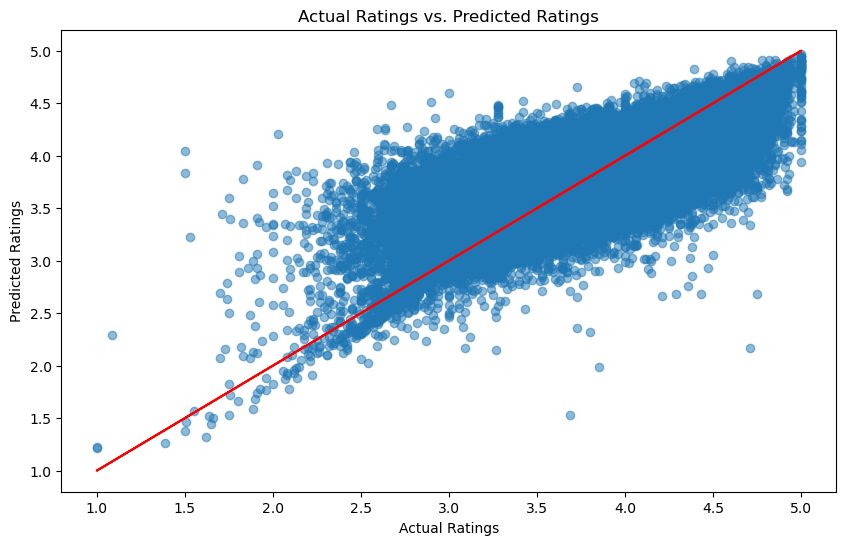

In [18]:
# Create a Scatter plot of actual versus predicted values
plt.figure(figsize=(10,6))
plt.scatter(ratings["Actual"], ratings["Predicted"], alpha=0.5)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual Ratings vs. Predicted Ratings")

# Ideal line for perfect predictions
plt.plot(ratings["Actual"], ratings["Actual"], color='red')

plt.show()


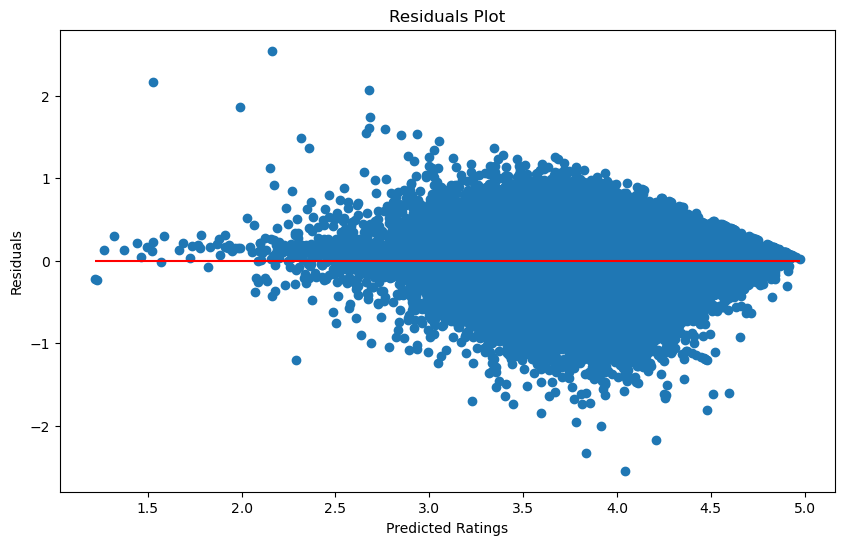

In [19]:
# Residual plot
residuals = ratings["Actual"] - ratings["Predicted"]
plt.figure(figsize=(10,6))
plt.scatter(ratings["Predicted"], residuals)
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.hlines(y=0, xmin=ratings["Predicted"].min(), xmax=ratings["Predicted"].max(), linestyles='-', color='red')
plt.show()

In [20]:
loss, mae, mse, r2_score = model.evaluate(X_test_scaled,y_test )
print("Test RSquare: ", r2_score)

6549/6549 [==============================] - 3s 382us/step - loss: 0.0538 - mean_absolute_error: 0.1668 - mean_squared_error: 0.0538 - r_square: 0.5881
Test RSquare:  0.5880917310714722


In [22]:
# Calculate the mean absolute error (MAE) and mean squared error (MSE)
mae = mean_absolute_error(ratings["Actual"], ratings["Predicted"])
mse = mean_squared_error(ratings["Actual"], ratings["Predicted"])


print(f'MAE: {mae}')
print(f'MSE: {mse}')



MAE: 0.16683703483885554
MSE: 0.05379331132359869


/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_14226/768085289.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
/var/folders/r1/l_chpxss1m9996z1bvjw88j40000gn/T/ipykernel_14226/768085289.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)


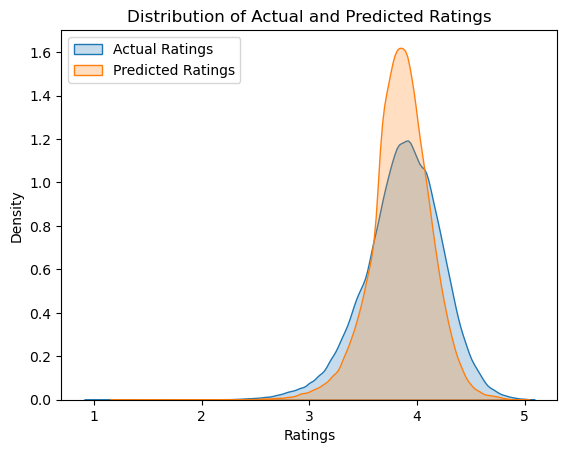

In [24]:
# Plot the distribution of actual and predicted ratings
sns.kdeplot(ratings["Actual"], label='Actual Ratings', shade=True)
sns.kdeplot(ratings["Predicted"], label='Predicted Ratings', shade=True)
plt.xlabel('Ratings')
plt.title('Distribution of Actual and Predicted Ratings')
plt.legend(loc='upper left')
plt.show()
